###Setting Enviorment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Tweet_Analysis


/content/drive/MyDrive/Tweet_Analysis


###Importing Libraries

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import re
import nltk
import gensim
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud,STOPWORDS
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from tqdm import tqdm
from sklearn.utils import shuffle
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Embedding, SpatialDropout1D, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from imblearn.metrics import classification_report_imbalanced


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
train = pd.read_csv("Tweets_train.csv")
test=pd.read_csv("Tweets_test.csv")
valid=pd.read_csv("Tweets_dev.csv")

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

funtion to clean the text

In [6]:
def clean_text(df):
    #1. Removing URLS
    df = re.sub('http\S+', '', df).strip()
    df = re.sub('www\S+', '', df).strip()

    
    #2.Decontracting words
    df = re.sub(r"won\'t", " will not", df)
    df = re.sub(r"won\'t've", " will not have", df)
    df = re.sub(r"can\'t", " can not", df)
    df = re.sub(r"don\'t", " do not", df)
    
    df = re.sub(r"can\'t've", " can not have", df)
    df = re.sub(r"ma\'am", " madam", df)
    df = re.sub(r"let\'s", " let us", df)
    df = re.sub(r"ain\'t", " am not", df)
    df = re.sub(r"shan\'t", " shall not", df)
    df = re.sub(r"sha\n't", " shall not", df)
    df = re.sub(r"o\'clock", " of the clock", df)
    df = re.sub(r"y\'all", " you all", df)
    df = re.sub(r"n\'t", " not", df)
    df = re.sub(r"n\'t've", " not have", df)
    df = re.sub(r"\'re", " are", df)
    df = re.sub(r"\'s", " is", df)
    df = re.sub(r"\'d", " would", df)
    df = re.sub(r"\'d've", " would have", df)
    df = re.sub(r"\'ll", " will", df)
    df = re.sub(r"\'ll've", " will have", df)
    df = re.sub(r"\'t", " not", df)
    df = re.sub(r"\'ve", " have", df)
    df = re.sub(r"\'m", " am", df)
    df = re.sub(r"\'re", " are", df)

    #3. Removing Tags
    df = re.sub('#\S+', '', df).strip()

    #4. Removing Mentions
    df = re.sub('@\S+', '', df).strip()

    
    #5. Removing upper brackets to keep negative auxiliary verbs in text
    df = df.replace("'", "")
    
    #6. Tokenize
    text_tokens = word_tokenize(df.lower())
    
    #7. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #8. Removing Stopwords
    stop_words = stopwords.words('english')
    for i in ["not", "no"]:
            stop_words.remove(i)
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #9. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]

    #joining
    return " ".join(text_cleaned)
   

In [7]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0

###Data Exploration

In [ ]:
train.shape

(11858, 3)

In [ ]:
valid.shape

(1318, 3)

In [ ]:
test.shape

(1464, 4)

In [ ]:
test.head(5)

In [ ]:
train.isnull().values.any()

False

In [ ]:
train.duplicated().sum()


91

In [ ]:
valid.duplicated().sum()

1

In [ ]:
test.duplicated().sum()

0

###EDA

sentiment distribution of the dataset  # inbalanced data

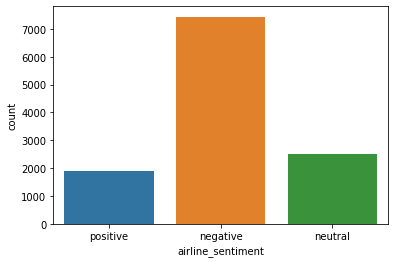

In [ ]:
import seaborn as sns
sns.countplot(x='airline_sentiment',data =train)

Wordcloud for tweets with Positive sentiment 

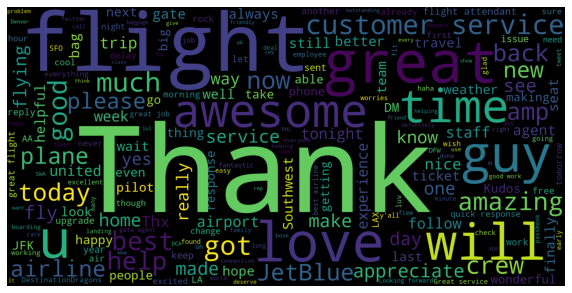

In [ ]:
new_df=train[train['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=2000,
                      height=1000
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Wordcloud for tweets with Neutral sentiment 

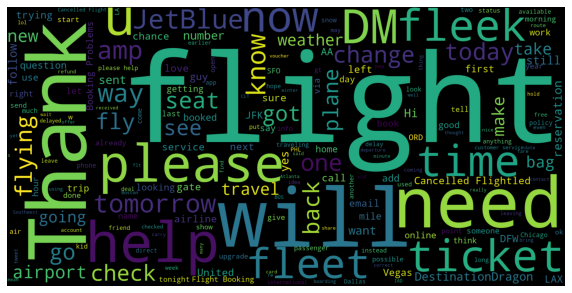

In [ ]:
new_df=train[train['airline_sentiment']=='neutral']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=2000,
                      height=1000
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Wordcloud for tweets with Negative sentiment 

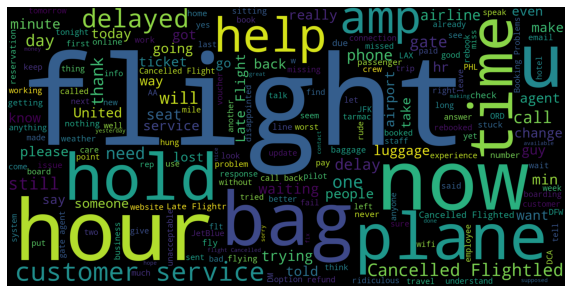

In [ ]:
new_df=train[train['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=2000,
                      height=1000
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

###Data Wrangling

We apply the clean function for all three datasets

In [8]:
train["clean_text"]=train["text"].apply(clean_text)
valid["clean_text"]=valid["text"].apply(clean_text)
test["clean_text"]=test["text"].apply(clean_text)

Drop duplicates

In [9]:
train.drop_duplicates("clean_text",inplace=True)
valid.drop_duplicates("clean_text",inplace=True)

we then convert the sentiments into integers

In [10]:
train.airline_sentiment = train.airline_sentiment.apply(lambda x : convert_Sentiment(x))
valid.airline_sentiment = valid.airline_sentiment.apply(lambda x : convert_Sentiment(x))
test.airline_sentiment = test.airline_sentiment.apply(lambda x : convert_Sentiment(x))

Splitting the Data into train and text variables

In [11]:
X_train = train['clean_text']
y_train = train['airline_sentiment']
X_valid = valid['clean_text']
y_valid = valid['airline_sentiment']
X_test = test['clean_text']
y_test = test['airline_sentiment']

###Modelling and Evaluation

Multinomial naive bayes pipeline

In [12]:
mnb_pipeline = Pipeline([('cv', CountVectorizer()),
                         #('tfidf', TfidfVectorizer()),  #0.74
                        ('mnb', MultinomialNB())
                       ])

params = {'cv__ngram_range': [(1, 1), (1, 2)],
    #'tfidf__ngram_range': [(1, 1), (1, 2)],
              'mnb__alpha': [0.001,0.01,0.1,1,10]
}

grid=HalvingGridSearchCV(estimator=mnb_pipeline, param_grid=params,factor=2, cv=5, 
                               scoring='f1_weighted',random_state=10,error_score=0)
grid.fit(X_train,y_train)

estimator = grid.best_estimator_

print(estimator)
y_pred = estimator.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
print(f'Validation accuracy: {accuracy}')

y_pred = estimator.predict(X_test)

print(classification_report_imbalanced(y_test, y_pred))


Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB(alpha=0.1))])
Validation accuracy: 0.7463377023901311
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.90      0.67      0.86      0.78      0.62       918
          1       0.63      0.51      0.92      0.56      0.69      0.45       310
          2       0.73      0.64      0.95      0.68      0.78      0.59       236

avg / total       0.77      0.77      0.77      0.77      0.76      0.58      1464



XGBoost Pipeline

In [ ]:
xgb_pipeline = Pipeline([('cv', CountVectorizer()),
                         #('tfidf', TfidfVectorizer()), #0.75
                        ('xgb', xgb.XGBClassifier())
                       ])

param_grid = {'cv__ngram_range': [(1, 1), (1, 2)],
              #'tfidf__ngram_range': [(1, 1), (1, 2)],
              'xgb__n_estimator': [10, 50, 100],
              'xgb__max_depth': [5,10, 50, 100]
}

grid = HalvingGridSearchCV(xgb_pipeline, param_grid, cv=5, verbose=1,n_jobs=-1)
grid.fit(X_train, y_train)

estimator = grid.best_estimator_
print(estimator)
y_pred = estimator.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
print(f'Validation accuracy: {accuracy}')

y_pred = estimator.predict(X_test)

print(classification_report_imbalanced(y_test, y_pred))

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1266
max_resources_: 11398
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 1266
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 8
n_resources: 3798
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 2
n_candidates: 3
n_resources: 11394
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('xgb',
                 XGBClassifier(max_depth=10, n_estimator=10,
                               objective='multi:softprob'))])
Validation accuracy: 0.7771781033153431
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.89      0.68      0.86      0.78      0.62       918
          1       0.62      0.55      0.91      0.58      0.71      0.49       310
          

A Random Forest pipeline 

In [ ]:
rf_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

params = {'cv__ngram_range': [(1, 1), (1, 2)],
          'rf__max_depth': [None,5, 10, 20, 50],
          'rf__n_estimators':[50,100,200],
          'rf__criterion':['gini','entropy']
}

grid=HalvingGridSearchCV(estimator=rf_pipeline, param_grid=params,factor=2, cv=5, 
                               scoring='f1_weighted',random_state=10,error_score=0)
grid.fit(X_train,y_train)


estimator = grid.best_estimator_

print(estimator)
y_pred = estimator.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
print(f'Validation accuracy: {accuracy}')

y_pred = estimator.predict(X_test)

print( classification_report_imbalanced(y_test, y_pred))


Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])
Validation accuracy: 0.7632999228989977
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.90      0.70      0.87      0.79      0.64       918
          1       0.62      0.45      0.92      0.52      0.64      0.39       310
          2       0.62      0.63      0.92      0.62      0.76      0.57       236

avg / total       0.75      0.76      0.78      0.75      0.76      0.58      1464



Balanced Random forest classifier 

In [ ]:
rf_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('brf', BalancedRandomForestClassifier())
])

params = {'cv__ngram_range': [(1, 1), (1, 2)],
          'brf__max_depth': [5, 10, 15, 20, 50],
          'brf__n_estimators':[50,100,200],
          'brf__criterion':['gini','entropy']
}

grid=HalvingGridSearchCV(estimator=rf_pipeline, param_grid=params,factor=2, cv=5, 
                               scoring='f1_weighted',random_state=10,error_score=0)
grid.fit(X_train,y_train)


estimator = grid.best_estimator_

print(estimator)
y_pred = estimator.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
print(f'Validation accuracy: {accuracy}')

y_pred = estimator.predict(X_test)

print(classification_report_imbalanced(y_test, y_pred))

Pipeline(steps=[('cv', CountVectorizer()),
                ('brf',
                 BalancedRandomForestClassifier(max_depth=15,
                                                n_estimators=200))])
Validation accuracy: 0.723207401696222
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.72      0.87      0.80      0.79      0.62       918
          1       0.48      0.70      0.79      0.57      0.75      0.55       310
          2       0.59      0.69      0.91      0.64      0.79      0.61       236

avg / total       0.76      0.71      0.86      0.73      0.78      0.60      1464



we load the GloVe vectors in a dictionary,we use the standford link http://www-nlp.stanford.edu/data/glove.840B.300d.zip to download the vectors

In [15]:
embeddings_index = {}
f = open('/content/drive/MyDrive/Tweet_Analysis/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:27, 14785.52it/s]

Found 400000 word vectors.


function to create normalized vector for the tweets

In [16]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

apply the function on our dataset

In [17]:
X_train_glove = [sent2vec(x) for x in tqdm(X_train)]
X_valid_glove = [sent2vec(x) for x in tqdm(X_valid)]
X_test_glove = [sent2vec(x) for x in tqdm(X_test)]

100%|██████████| 1464/1464 [00:00<00:00, 2169.73it/s]


encode our target labels

In [18]:
y_train_enc = np_utils.to_categorical(y_train)
y_valid_enc = np_utils.to_categorical(y_valid)
y_test_enc  = np_utils.to_categorical(y_test)

We scale our features using standard scaler()

In [19]:
scl = StandardScaler()
X_train_glove_scl = scl.fit_transform(X_train_glove)
X_valid_glove_scl = scl.transform(X_valid_glove)
X_test_glove_scl = scl.transform(X_test_glove)

In [20]:
frequencies = pd.value_counts(train['airline_sentiment']) 
class_weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1],2: frequencies.sum() / frequencies[2]}

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00001)

##simple neural network

A simple 3 layer neural network


In [ ]:
snn_model = Sequential()

snn_model.add(Dense(300, input_dim=300, activation='relu'))
snn_model.add(Dropout(0.8))
snn_model.add(BatchNormalization())

snn_model.add(Dense(300, activation='relu'))
snn_model.add(Dropout(0.8))
snn_model.add(BatchNormalization())


snn_model.add(Dense(3))
snn_model.add(Activation('softmax'))
snn_model.summary()

# compile the model
snn_model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               90300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                        

In [ ]:
snn_history=snn_model.fit(X_train_glove_scl, y=y_train_enc, batch_size=64, 
          epochs=20, verbose=1, 
          validation_data=(X_valid_glove_scl, y_valid_enc),class_weight=class_weights,callbacks=[learning_rate_reduction])

Epoch 1/20
179/179 [==============================] - 3s 7ms/step - loss: 3.8976 - accuracy: 0.4074 - val_loss: 0.8019 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 2/20
179/179 [==============================] - 1s 6ms/step - loss: 2.9405 - accuracy: 0.5261 - val_loss: 0.7646 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 3/20
179/179 [==============================] - 1s 8ms/step - loss: 2.6779 - accuracy: 0.5924 - val_loss: 0.7686 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 4/20
179/179 [==============================] - 1s 7ms/step - loss: 2.5149 - accuracy: 0.6218 - val_loss: 0.7475 - val_accuracy: 0.6831 - lr: 0.0010
Epoch 5/20
179/179 [==============================] - 3s 15ms/step - loss: 2.4499 - accuracy: 0.6341 - val_loss: 0.7280 - val_accuracy: 0.6901 - lr: 0.0010
Epoch 6/20
179/179 [==============================] - 2s 13ms/step - loss: 2.3905 - accuracy: 0.6481 - val_loss: 0.7256 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 7/20
179/179 [==============================] - 2s 10ms/step -

In [ ]:
loss, accuracy = snn_model.evaluate(X_test_glove_scl, y_test_enc)
print("loss", loss)
print("accuracy", accuracy)

46/46 [==============================] - 0s 2ms/step - loss: 0.6798 - accuracy: 0.7234
loss 0.6798271536827087
accuracy 0.7233606576919556


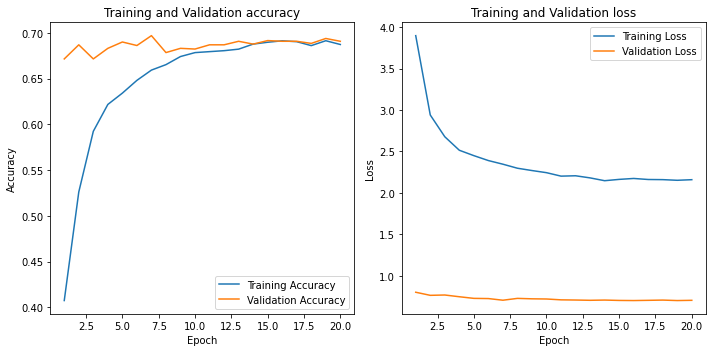

In [ ]:
accuracy = snn_history.history['accuracy']
val_accuracy = snn_history.history['val_accuracy']
loss = snn_history.history['loss']
val_loss = snn_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
fig , ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(epochs,snn_history.history['accuracy'],label = 'Training Accuracy')
ax[0].plot(epochs,snn_history.history['val_accuracy'],label = 'Validation Accuracy')
ax[0].set_title('Training and Validation accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs,snn_history.history['loss'],label = 'Training Loss')
ax[1].plot(epochs,snn_history.history['val_loss'],label = 'Validation Loss')
ax[1].set_title('Training and Validation loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
fig.tight_layout()
plt.show()

In [ ]:
snn_model.save('/content/drive/MyDrive/Tweet_Analysis/snn.hdf5')

In [ ]:
y_pred_snn=snn_model.predict(X_test_glove_scl) 
print(confusion_matrix(np.argmax(y_test_enc, axis=1), np.argmax(y_pred_snn, axis=1)))
print(classification_report_imbalanced(np.argmax(y_test_enc, axis=1), np.argmax(y_pred_snn, axis=1)))


46/46 [==============================] - 0s 2ms/step
[[673 157  88]
 [ 55 190  65]
 [ 15  25 196]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.73      0.87      0.81      0.80      0.63       918
          1       0.51      0.61      0.84      0.56      0.72      0.50       310
          2       0.56      0.83      0.88      0.67      0.85      0.72       236

avg / total       0.77      0.72      0.87      0.73      0.79      0.62      1464



##LSTM

to perform LSTM RNN we need to tokenize the data,so we use keras Tokenizer

In [13]:
token = text.Tokenizer(num_words=None)
max_len = 120

token.fit_on_texts(list(X_train) + list(X_valid))
X_train_seq = token.texts_to_sequences(X_train)
X_valid_seq = token.texts_to_sequences(X_valid)
X_test_seq = token.texts_to_sequences(X_test)

# zero pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

word_index = token.word_index

creating embedding matrix for the words to use in embedding layer

In [22]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 8215/8215 [00:00<00:00, 73002.60it/s]


In [25]:
LSTM_model = Sequential()
LSTM_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
LSTM_model.add(SpatialDropout1D(0.3))
LSTM_model.add(LSTM(120, dropout=0.3, recurrent_dropout=0.3))

LSTM_model.add(Dense(256, activation='relu'))
LSTM_model.add(Dropout(0.5))

LSTM_model.add(Dense(256, activation='relu'))
LSTM_model.add(Dropout(0.5))

LSTM_model.add(Dense(256, activation='relu'))
LSTM_model.add(Dropout(0.5))

LSTM_model.add(Dense(3))
LSTM_model.add(Activation('softmax'))

LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])



In [26]:
LSTM_history = LSTM_model.fit(X_train_pad, y=y_train_enc, batch_size=256, epochs=25, verbose=1, validation_data=(X_valid_pad, y_valid_enc),class_weight=class_weights,callbacks=[learning_rate_reduction])

Epoch 1/25
45/45 [==============================] - 29s 541ms/step - loss: 3.0942 - accuracy: 0.5039 - val_loss: 0.7514 - val_accuracy: 0.7001 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - 23s 501ms/step - loss: 2.4579 - accuracy: 0.6598 - val_loss: 0.6680 - val_accuracy: 0.7355 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - 23s 503ms/step - loss: 2.2399 - accuracy: 0.6828 - val_loss: 0.6657 - val_accuracy: 0.7155 - lr: 0.0010
Epoch 4/25
45/45 [==============================] - 27s 597ms/step - loss: 2.1836 - accuracy: 0.7008 - val_loss: 0.6136 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 5/25
45/45 [==============================] - 23s 505ms/step - loss: 2.1143 - accuracy: 0.7073 - val_loss: 0.6343 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 6/25
45/45 [==============================] - 24s 535ms/step - loss: 2.0786 - accuracy: 0.7114 - val_loss: 0.6524 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 7/25
45/45 [==============================] - 23s 503ms/st

In [33]:
LSTM_model.save('/content/drive/MyDrive/Tweet_Analysis/LSTM_1.hdf5')

In [29]:
loss, accuracy = LSTM_model.evaluate(X_test_pad, y_test_enc)
print("loss", loss)
print("accuracy", accuracy)

46/46 [==============================] - 2s 35ms/step - loss: 0.5809 - accuracy: 0.7520
loss 0.5809187293052673
accuracy 0.7520492076873779


In [28]:
y_pred = LSTM_model.predict(X_test_pad)

46/46 [==============================] - 2s 34ms/step


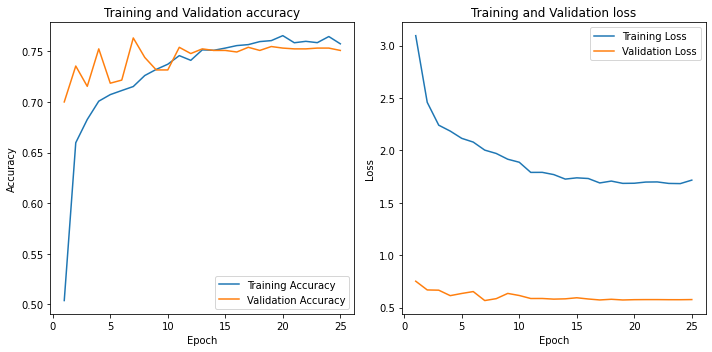

In [30]:
accuracy = LSTM_history.history['accuracy']
val_accuracy = LSTM_history.history['val_accuracy']
loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
fig , ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(epochs,LSTM_history.history['accuracy'],label = 'Training Accuracy')
ax[0].plot(epochs,LSTM_history.history['val_accuracy'],label = 'Validation Accuracy')
ax[0].set_title('Training and Validation accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs,LSTM_history.history['loss'],label = 'Training Loss')
ax[1].plot(epochs,LSTM_history.history['val_loss'],label = 'Validation Loss')
ax[1].set_title('Training and Validation loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
fig.tight_layout()
plt.show()

In [31]:
y_pred_LSTM = LSTM_model.predict(X_test_pad)
print(confusion_matrix(np.argmax(y_test_enc, axis=1), np.argmax(y_pred_LSTM, axis=1)))
print(classification_report_imbalanced(np.argmax(y_test_enc, axis=1), np.argmax(y_pred_LSTM, axis=1)))

46/46 [==============================] - 2s 33ms/step
[[699 155  64]
 [ 50 212  48]
 [ 18  28 190]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.76      0.88      0.83      0.82      0.66       918
          1       0.54      0.68      0.84      0.60      0.76      0.57       310
          2       0.63      0.81      0.91      0.71      0.86      0.72       236

avg / total       0.79      0.75      0.87      0.76      0.81      0.65      1464



###Bi-directional LSTM

In [36]:
bi_LSTM_model = Sequential()
bi_LSTM_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
bi_LSTM_model.add(SpatialDropout1D(0.3))
bi_LSTM_model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

bi_LSTM_model.add(Dense(512, activation='relu'))
bi_LSTM_model.add(Dropout(0.6))

bi_LSTM_model.add(Dense(512, activation='relu'))
bi_LSTM_model.add(Dropout(0.6))

bi_LSTM_model.add(Dense(512, activation='relu'))
bi_LSTM_model.add(Dropout(0.6))

bi_LSTM_model.add(Dense(3))
bi_LSTM_model.add(Activation('softmax'))
bi_LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


bi_LSTM_history=bi_LSTM_model.fit(X_train_pad, y=y_train_enc, batch_size=256, epochs=25, 
          verbose=1, validation_data=(X_valid_pad, y_valid_enc),class_weight=class_weights,callbacks=[learning_rate_reduction])

Epoch 1/25
45/45 [==============================] - 52s 1000ms/step - loss: 2.9472 - accuracy: 0.5472 - val_loss: 0.6906 - val_accuracy: 0.7124 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - 49s 1s/step - loss: 2.3784 - accuracy: 0.6742 - val_loss: 0.7722 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - 45s 1s/step - loss: 2.2464 - accuracy: 0.6926 - val_loss: 0.6297 - val_accuracy: 0.7463 - lr: 0.0010
Epoch 4/25
45/45 [==============================] - 45s 999ms/step - loss: 2.1564 - accuracy: 0.6990 - val_loss: 0.6782 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 5/25
45/45 [==============================] - 46s 1s/step - loss: 2.1175 - accuracy: 0.7075 - val_loss: 0.6810 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 6/25
45/45 [==============================] - ETA: 0s - loss: 2.0487 - accuracy: 0.7139
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
45/45 [==============================] - 50s 1s/step - los

In [38]:
bi_LSTM_model.save('/content/drive/MyDrive/Tweet_Analysis/bi_LSTM_1.hdf5')

In [41]:
loss, accuracy =bi_LSTM_model.evaluate(X_test_pad, y_test_enc)
print("loss", loss)
print("accuracy", accuracy)

46/46 [==============================] - 5s 99ms/step - loss: 0.5994 - accuracy: 0.7329
loss 0.5994300842285156
accuracy 0.7329235076904297


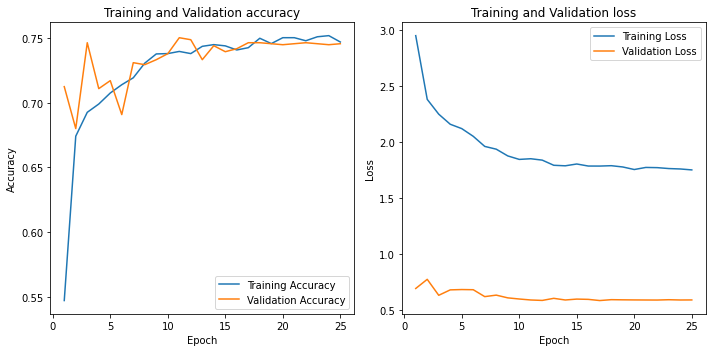

In [39]:
accuracy = bi_LSTM_history.history['accuracy']
val_accuracy = bi_LSTM_history.history['val_accuracy']
loss = bi_LSTM_history.history['loss']
val_loss = bi_LSTM_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
fig , ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(epochs,bi_LSTM_history.history['accuracy'],label = 'Training Accuracy')
ax[0].plot(epochs,bi_LSTM_history.history['val_accuracy'],label = 'Validation Accuracy')
ax[0].set_title('Training and Validation accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs,bi_LSTM_history.history['loss'],label = 'Training Loss')
ax[1].plot(epochs,bi_LSTM_history.history['val_loss'],label = 'Validation Loss')
ax[1].set_title('Training and Validation loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
fig.tight_layout()
plt.show()

In [40]:
y_pred_bi = bi_LSTM_model.predict(X_test_pad)
print(confusion_matrix(np.argmax(y_test_enc, axis=1), np.argmax(y_pred_bi, axis=1)))
print(classification_report_imbalanced(np.argmax(y_test_enc, axis=1), np.argmax(y_pred_bi, axis=1)))

46/46 [==============================] - 5s 95ms/step
[[675 174  69]
 [ 52 208  50]
 [ 15  31 190]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.74      0.88      0.81      0.80      0.64       918
          1       0.50      0.67      0.82      0.58      0.74      0.54       310
          2       0.61      0.81      0.90      0.70      0.85      0.72       236

avg / total       0.78      0.73      0.87      0.74      0.80      0.63      1464

